In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

from modules.data_fetcher import download_historical_data


In [2]:
symbol = "BTC-USDT"

df_BTC = download_historical_data(symbol, "1day").loc["2020-11-20":]

df_BTC["Log_Close"] = np.log(df_BTC.Close.apply(lambda x: 1.0 if x == 0.0 else x))
df_BTC["Returns"] = df_BTC.Close.pct_change()
df_BTC["Log_Returns"] = df_BTC.Log_Close.pct_change()
df_BTC["Log_Volume"] = np.log(
    np.abs(df_BTC.Volume.apply(lambda x: 1.0 if x == 0.0 else x))
)
df_BTC["Vol20"] = df_BTC.Log_Returns.rolling(20).std()
df_BTC["EMA20"] = df_BTC.Close.ewm(20).mean()


df_BTC.dropna(inplace=True)
print(df_BTC.shape)
df_BTC.head()

(850, 13)


,Timestamp,Open,Close,High,Low,Amount,Volume,Log_Close,Returns,Log_Returns,Log_Volume,Vol20,EMA20
Date,,,,,,,,,,,,,
2020-12-10 01:00:00,1607558400,18540.0,18251.2,18552.2,17913.4,1255.370680,2.292105e+07,9.811986,-0.015582,-0.001598,16.947566,0.003780,18649.510967
2020-12-11 01:00:00,1607644800,18251.4,18027.0,18288.9,17584.2,1845.597719,3.304855e+07,9.799626,-0.012284,-0.001260,17.313488,0.003788,18604.470515
2020-12-12 01:00:00,1607731200,18035.9,18806.8,18942.1,18020.9,968.568285,1.792373e+07,9.841974,0.043257,0.004321,16.701636,0.003902,18618.756291
2020-12-13 01:00:00,1607817600,18809.8,19176.1,19411.0,18715.0,1285.871491,2.465229e+07,9.861420,0.019637,0.001976,17.020380,0.003923,18657.224101
2020-12-14 01:00:00,1607904000,19176.1,19271.1,19348.2,19002.2,830.182795,1.591667e+07,9.866362,0.004954,0.000501,16.582877,0.003808,18698.706009


<Axes: xlabel='EMA20', ylabel='Close'>

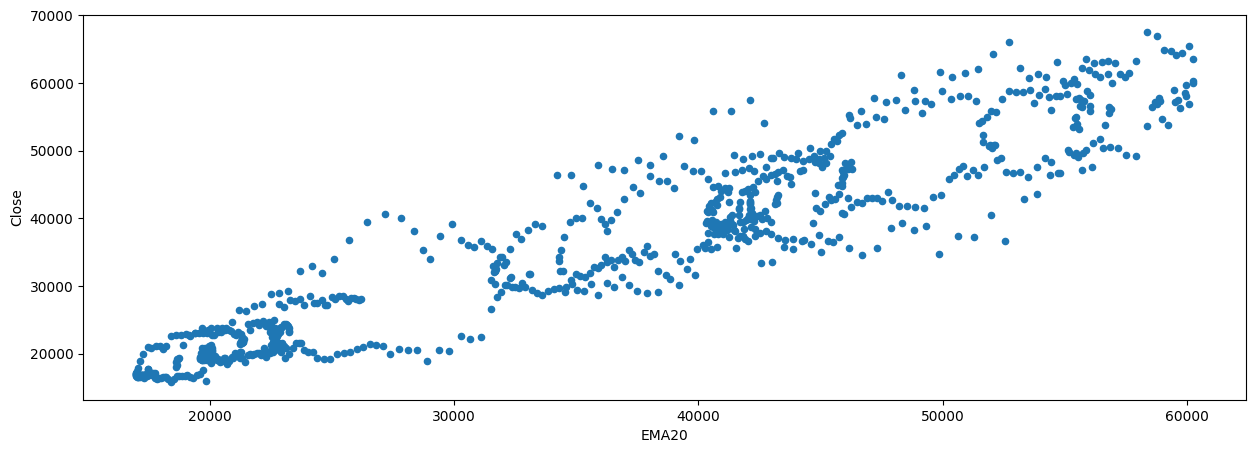

In [10]:
df_BTC.plot(x="EMA20", y="Close", figsize=(15, 5),kind="scatter")

In [13]:
# split into inputs and outputs
X, y = df_BTC.EMA20.values.reshape(-1,1), df_BTC.Close.values


In [27]:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.compose import TransformedTargetRegressor


# prepare the model with input scaling
pipeline = Pipeline(steps=[('power', MinMaxScaler()), ('model', HuberRegressor())])

# prepare the model with target scaling
model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
# evaluate model
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=4)
# convert scores to positive
scores

array([-3684.32616576, -3398.43134479, -4115.03899824, -3604.50840841,
       -4065.35589176, -3325.92005141, -3977.02378127, -3478.60370375,
       -3303.19113427, -3597.23207969])

In [28]:
model.fit(X,y)
model.score(X,y)

0.882375301675448

In [29]:
# prepare the model with input scaling
pipeline = Pipeline(steps=[('power', MinMaxScaler()), ('model', HuberRegressor())])

# prepare the model with target scaling
#model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())
pipeline.fit(X,y)
pipeline.score(X,y)

0.8822838922643153